## Linear Classification with Twitter NLP

## Background Overview

News agencies, governments and corporations sometimes track social media during natural disasters to try to monitor unfolding events. But because no single person or group of people can read all available Twitter data, organizations may turn to natural language processing methods to try and understand what is happening as disasters unfold. 

While this approach is powerful, inferring events from NLP can be tricky. For instance, say a person [tweets](https://twitter.com/AnyOtherAnnaK/status/629195955506708480) that "LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE." This tweet includes the word "ablaze", which may signal to a computer that there is an unfolding disaster. However, in this particular case, the person is speaking metaphorically. A simple computer system using keywords (e.g. ablaze) might be fooled into thinking the tweet is reporting an actual fire.

With this data I am predicting if a given tweet actually refers to a natural disaster. This exercise is motivated by real-world disaster monitoring systems, and uses a supervised binary classification and natural language processing.

__Note__: This dataset originally comes from [Kaggle](https://www.kaggle.com/c/nlp-getting-started/overview). But it has been modified for this problem set. Information about the data from this problem set that you find on Kaggle will almost certainly be wrong.


## Explaining the problems and models
Experimenting with perceptron and logistic regression in `sklearn`. Using `SGDClassifier` ([sklearn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)),  implements stochastic gradient descent (SGD) for a variety of loss functions, including both perceptron and logistic regression, allowing them to easily move between the two classifiers.

The code below loads the datasets. There are two data collections: the "training" data, which contains the tweets that will be used for training the classifiers, and the "testing" data, which are tweets that you will use to measure the classifier accuracy. The test tweets are instances that the classifier has never seen before. They represent a good way to see how the classifier will behave on data it hasn't seen before. However, the labels of the test tweets are known and can measure the accuracy.

I included "bag of words" features, which are commonly used when doing classification with text. Each feature is a word, and the value of a feature for a particular tweet is number of times the word appears in the tweet (with value $0$ if the word does not appear in the tweet).

A note on the labels: **If `Y_train` or `Y_test` are 1 this means the tweet refers to a real disaster; if the values are 0, it means the tweet does not refer to a real disaster** 

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# reading into the csv file train
df_train = pd.read_csv('train.csv')

# reads into the train columns target and text. target had 6120 1s, text has records of accidents
Y_train = df_train["target"]
text_train = df_train["text"]

# X_train is a vector matrix with almost 90k elemnts, in row format
vec = CountVectorizer()
X_train = vec.fit_transform(text_train)

# feature names is an array with weird values
feature_names = np.asarray(vec.get_feature_names())

# df test reads the test csv, Y_test is the target column, 
# lots of 1s. text_test is the text column of accidents.
df_test = pd.read_csv('test.csv')
Y_test = df_test["target"]
text_test = df_test["text"]

X_test = vec.transform(text_test)
# these are the different tests below
#Y_train
#text_train
#X_train
#df_train
#feature_names
df_test
#Y_test
#text_test

,Unnamed: 0,id,keyword,location,text,target
0,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
1,7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
2,16,24,NaN,NaN,I love fruits,0
3,18,26,NaN,NaN,My car is so fast,0
4,26,38,NaN,NaN,Was in NYC last week!,0
...,...,...,...,...,...,...
1488,7585,10839,NaN,NaN,Calgary Police Flood Road Closures in Calgary....,1
1489,7596,10851,NaN,NaN,RT @LivingSafely: #NWS issues Severe #Thunders...,1
1490,7601,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1
1491,7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1


The variables `df_train` and `df_test` are dataframes that store the training (and testing) datasets, which are contained in csv files where the first column is the label and the second column is the text of the tweet.

The [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class converts the raw text into a bag-of-words into a feature vector representation that `sklearn` can use.


#### Deliverable 1.1

How many training instances are in the dataset? How many test instances? 

    6120 training instances and 1493 testing instances

#### Deliverable 1.2

How many features are in the training data?

    6 features are in the training data.

#### Deliverable 1.3

What is the distribution of labels in the training data? That is, what percentage of instances are about actual disasters?
    
        The percentage of instances that are natural disasters, is 43.2%. This is based on the data showing 2644 natural disasters and then dividing by the total instances, 6120.

In [6]:
df_train["target"].value_counts()

0    3476
1    2644
Name: target, dtype: int64

In [7]:
2644 / 6120

0.4320261437908497

## SGDC Classifier
The code below trains an [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) using the perceptron loss, then it measures the accuracy of the classifier on the test data, using `sklearn`'s [`accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function. 

The `fit` function trains the classifier. The feature weights are stored in the `coef_` variable after training. The `predict` function of the trained `SGDClassifier` outputs the predicted label for a given instance or list of instances.

Additionally, this code displays the features and their weights in sorted order, which you may want to examine to understand what the classifier is learning. In general, in binary classification, the 0 class is considered the "negative" class.

There are 3 keyword arguments that have been added to the code below. It is important you keep the same values of these arguments whenever you create an `SGDClassifier` instance in this assignment so that you get consistent results. They are:

- `max_iter` is one of the stopping criteria, which is the maximum number of iterations/epochs the algorithm will run for.

- `tol` is the other stopping criterion, which is how small the difference between the current loss and previous loss should be before stopping.

- `random_state` is a seed for pseudorandom number generation. The algorithm uses randomness in the way the training data are sorted, which will affect the solution that is learned, and even the accuracy of that solution.

Note: The loss function is convex, so the algorithm will find the same minimum regardless of how it is trained. Why is there random variation in the output? The reason is that even though there is only one minimum value of the loss, there may be different weights that result in the same loss, so randomness is a matter of tie-breaking. What's more, while different weights may have the same loss, they could lead to different classification accuracies, because the loss function is not the same as accuracy. (Unless accuracy was your loss function... which is possible, but uncommon because it turns out to be a difficult function to optimize.)
Note that different computers may still give different answers, despite keeping these settings the same, because of how pseudorandom numbers are generated with different operating systems and Python environments.*

To begin, run the code in the cell below without modification.

In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score

classifier = SGDClassifier(loss='perceptron', max_iter=1000, tol=1.0e-12, random_state=123, eta0=100)
classifier.fit(X_train, Y_train)

print("Number of SGD iterations: %d" % classifier.n_iter_)
print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

print("\nFeature weights:")
args = np.argsort(classifier.coef_[0])

print("\n - lowest")
for a in args[0:5]:
    print("\t %s: %0.4f" % (feature_names[a], classifier.coef_[0][a]))
   
print("\n - highest")
for a in args[-5:]:
    print("\t %s: %0.4f" % (feature_names[a], classifier.coef_[0][a]))

Number of SGD iterations: 35
Training accuracy: 0.987908
Testing accuracy: 0.781648

Feature weights:

 - lowest
	 zy3hpdjnwg: -0.7900
	 qzlpfhpwdo: -0.6970
	 better: -0.5112
	 f7wqpcekg2: -0.5112
	 sun: -0.5112

 - highest
	 storm: 0.8829
	 sunburned: 0.9294
	 hurricane: 0.9294
	 massacre: 1.0688
	 earthquake: 1.2547


#### Deliverable 2.1

Based on the training accuracy, do you conclude that the data are (mostly) linearly separable? Why or why not?

    Yes, because the number is statistically significant. The training accuracy is at 98.79%, which in a perceptron means it is linearly separable.

#### Deliverable 2.2

Which feature most increases the likelihood that the tweet does not refer to a real disaster, and which feature most increases the likelihood that the tweet refers to a real disaster? 

    The feature that most likely refers to a tweet of a real disatster is earthquake. It has the highest weight. While, zy3hpdjnwg has the lowest weight making it the least likely tweet to refer to a real disaster.

#### Deliverable 2.3 
One technique for improving the resulting model with perceptron is to take an average of the weight vectors learned at different iterations of the algorithm, rather than only using the final weights that minimize the loss. That is, calculate $\bar{\mathbf{w}} = \sum_{t=1}^T \mathbf{w}^{(t)}$ where $\mathbf{w}^{(t)}$ is the weight vector at iteration $t$ of the algorithm and $T$ is the number of iterations, and then use $\bar{\mathbf{w}}$ when making classifications on new data.

To use this technique in your classifier, add the keyword argument `average=True` to the `SGDClassifier` function. Try it now using the cells below.

Compare the initial training/test accuracies to the training/test accuracies after doing averaging. What happens? Why do you think averaging the weights from different iterations has this effect?

In [46]:
a = 97.71 - 98.79
b = 81.17 - 78.16 
a + b

1.9299999999999926

In [55]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score

classifier = SGDClassifier(loss='perceptron', max_iter=1000, tol=1.0e-12, random_state=123, eta0=100, average = True)
classifier.fit(X_train, Y_train)

print("Number of SGD iterations: %d" % classifier.n_iter_)
print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

print("\nFeature weights:")
args = np.argsort(classifier.coef_[0])

print("\n - lowest")
for a in args[0:5]:
    print("\t %s: %0.4f" % (feature_names[a], classifier.coef_[0][a]))
   
print("\n - highest")
for a in args[-5:]:
    print("\t %s: %0.4f" % (feature_names[a], classifier.coef_[0][a]))

Number of SGD iterations: 35
Training accuracy: 0.977124
Testing accuracy: 0.811788

Feature weights:

 - lowest
	 full: -1.6394
	 sun: -1.3797
	 better: -1.3130
	 also: -1.3088
	 book: -1.2684

 - highest
	 storm: 2.0315
	 earthquake: 2.0326
	 floods: 2.0351
	 fires: 2.1129
	 hiroshima: 2.1832


    The training accuracy decreased to 97.71%, while the testing accuracy increased to 81.17%, for an overall increase in accuracy of approximately 2%. This is because the perceptron is combining the predicted outcomes of each iteration, and averages those outcomes for higher accuracy.

## Logistic regression

For this problem, create a new `SGDClassifier`, this time setting the `loss` argument to `'log'`, which will train a logistic regression classifier. Set `average=False` for the remaining problems.

Once you have trained the classifier, you can use the `predict` function to get the classifications, as with perceptron. Additionally, logistic regression provides probabilities for the predictions. You can get the probabilities by calling the `predict_proba` function. This will give a list of two numbers; the first is the probability that the class is $0$ and the second is the probability that the class is $1$.


For the first task, add the keyword argument `alpha` to the `SGDClassifier` function. This is the regularization strength, called $\lambda$ in lecture. If you don't specify `alpha`, it defaults to $0.0001$. Experiment with other values and see how this affects the outcome.

#### Deliverable 3.1: 

Calculated the training and testing accuracy when `alpha` is one of $[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]$. Created a plot where the x-axis is `alpha` and the y-axis is accuracy, with two lines (one for training and one for testing). You can borrow the code from HW1 for generating plots in Python. Use [a log scale for the x-axis](https://matplotlib.org/examples/pylab_examples/log_demo.html) so that the `alpha` values are spaced evenly.


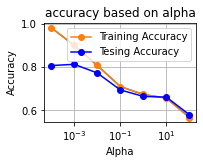

In [24]:
# starter code

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score

classifier = SGDClassifier(loss = 'log', max_iter = 1000, alpha = 0.01, tol = 1.0e-12, random_state = 123, eta0 = 100, average = False)
classifier.fit(X_train, Y_train)
 
training_Accuracy = [0,0,0,0,0,0,0]

testing_Accuracy = [0,0,0,0,0,0,0]


c1 = SGDClassifier(loss = 'log', max_iter = 1000, alpha = 0.0001, tol = 1.0e-12, random_state = 123, eta0 = 100, average = False)
c1.fit(X_train, Y_train)


c2 = SGDClassifier(loss = 'log', max_iter = 1000, alpha = 0.001, tol = 1.0e-12, random_state = 123, eta0 = 100, average = False)
c2.fit(X_train, Y_train)


c3 = SGDClassifier(loss = 'log', max_iter = 1000, alpha = 0.01, tol = 1.0e-12, random_state = 123, eta0 = 100, average=False)
c3.fit(X_train, Y_train)


c4 = SGDClassifier(loss = 'log', max_iter = 1000, alpha = 0.1, tol = 1.0e-12, random_state = 123, eta0 = 100, average = False)
c4.fit(X_train, Y_train)

c5 = SGDClassifier(loss = 'log', max_iter = 1000, alpha = 1.0, tol = 1.0e-12, random_state = 123, eta0 = 100, average = False)
c5.fit(X_train, Y_train)

 
c6 = SGDClassifier(loss = 'log', max_iter = 1000, alpha = 10, tol = 1.0e-12, random_state = 123, eta0 = 100, average = False)
c6.fit(X_train, Y_train)


c7 = SGDClassifier(loss = 'log', max_iter = 1000, alpha = 100, tol = 1.0e-12, random_state = 123, eta0 = 100, average=False)
c7.fit(X_train, Y_train)


training_Accuracy[0] = accuracy_score(Y_train, c1.predict(X_train))
training_Accuracy[1] = accuracy_score(Y_train, c2.predict(X_train))
training_Accuracy[2] = accuracy_score(Y_train, c3.predict(X_train))
training_Accuracy[3] = accuracy_score(Y_train, c4.predict(X_train))
training_Accuracy[4] = accuracy_score(Y_train, c5.predict(X_train))
training_Accuracy[5] = accuracy_score(Y_train, c6.predict(X_train))
training_Accuracy[6] = accuracy_score(Y_train, c7.predict(X_train))

testing_Accuracy[0] = accuracy_score(Y_test, c1.predict(X_test))
testing_Accuracy[1] = accuracy_score(Y_test, c2.predict(X_test))
testing_Accuracy[2] = accuracy_score(Y_test, c3.predict(X_test))
testing_Accuracy[3] = accuracy_score(Y_test, c4.predict(X_test))
testing_Accuracy[4] = accuracy_score(Y_test, c5.predict(X_test))
testing_Accuracy[5] = accuracy_score(Y_test, c6.predict(X_test))
testing_Accuracy[6] = accuracy_score(Y_test, c7.predict(X_test))

alpha = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

plt.subplot(222)
plt.semilogx(alpha, training_Accuracy)
plt.grid(True)

plt.title('accuracy based on alpha')
plt.plot(alpha, training_Accuracy, label = 'Training Accuracy', marker = 'o')
plt.plot(alpha, testing_Accuracy, label = 'Tesing Accuracy', marker = 'o', color = "blue")
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()


#### Deliverable 3.2

Examine the classifier probabilities using the `predict_proba` function when training with different values of `alpha`. What do you observe? How does `alpha` affect the prediction probabilities, and why do you think this happens?

    As the value of alpha increases the overall accuracy of predict_proba, and both the training and testing data gets worse. When alpha is at 0.0001 it is at its most accurate. Any smaller or larger and it becomes less accurate. This is because it calculates the penalty and 0.0001 fits the weights the most for optimizing the training and testing accuracy. 

In [42]:
c1.predict_proba(X_train)

array([[0.1073517 , 0.8926483 ],
       [0.07474336, 0.92525664],
       [0.04847949, 0.95152051],
       ...,
       [0.00976061, 0.99023939],
       [0.04878059, 0.95121941],
       [0.00382533, 0.99617467]])

In [45]:
c2.predict_proba(X_train)

array([[0.35321656, 0.64678344],
       [0.16869801, 0.83130199],
       [0.13702526, 0.86297474],
       ...,
       [0.03844073, 0.96155927],
       [0.18279678, 0.81720322],
       [0.03216899, 0.96783101]])

In [46]:
c3.predict_proba(X_train)

array([[0.53629373, 0.46370627],
       [0.32635411, 0.67364589],
       [0.30038956, 0.69961044],
       ...,
       [0.18228622, 0.81771378],
       [0.32799007, 0.67200993],
       [0.18481425, 0.81518575]])

In [47]:
c4.predict_proba(X_train)

array([[0.54681201, 0.45318799],
       [0.46917619, 0.53082381],
       [0.44543801, 0.55456199],
       ...,
       [0.44182658, 0.55817342],
       [0.46094343, 0.53905657],
       [0.41797239, 0.58202761]])

In [48]:
c5.predict_proba(X_train)

array([[0.51459256, 0.48540744],
       [0.50241214, 0.49758786],
       [0.49491548, 0.50508452],
       ...,
       [0.5094737 , 0.4905263 ],
       [0.49789611, 0.50210389],
       [0.49055035, 0.50944965]])

In [49]:
c6.predict_proba(X_train)

array([[0.50239332, 0.49760668],
       [0.50106973, 0.49893027],
       [0.50015043, 0.49984957],
       ...,
       [0.50220857, 0.49779143],
       [0.50048597, 0.49951403],
       [0.49968586, 0.50031414]])

In [50]:
c7.predict_proba(X_train)

array([[0.50056581, 0.49943419],
       [0.50043237, 0.49956763],
       [0.50033777, 0.49966223],
       ...,
       [0.50055279, 0.49944721],
       [0.50037189, 0.49962811],
       [0.50029223, 0.49970777]])

In [44]:
training_Accuracy

[0.9833333333333333,
 0.9016339869281046,
 0.8086601307189543,
 0.7107843137254902,
 0.6741830065359478,
 0.6570261437908497,
 0.5674836601307189]

In [26]:
testing_Accuracy

[0.8077695914266577,
 0.8137977227059612,
 0.7736101808439384,
 0.695244474212994,
 0.6651038178164769,
 0.6617548559946417,
 0.580040187541862]

#### Deliverable 3.3: 

Now remove the `alpha` argument so that it goes back to the default value. We'll now look at the effect of the learning rate. By default, `sklearn` uses an "optimal" learning rate based on some heuristics that work well for many problems. However, it can be good to see how the learning rate can affect the algorithm.

For this task, add the keyword argument `learning_rate` to the `SGDClassifier` function and set the value to `invscaling`. This defines the learning rate at iteration $t$ as: $\eta_t = \frac{\eta_0}{t^a}$, where $\eta_0$ and $a$ are both arguments you have to define in the `SGDClassifier` function, called `eta0` and `power_t`, respectively. Experiment with different values of `eta0` and `power_t` and see how they affect the number of iterations it takes the algorithm to converge. You will often find that it will not finish within the maximum of $1000$ iterations.

In [40]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score

classifier = SGDClassifier(loss = 'log', max_iter = 1000, eta0 = 10000, power_t = 2.0, learning_rate = "invscaling", tol = 1.0e-12, random_state = 123, average = False)
classifier.fit(X_train, Y_train)


/Users/johnnyparkerlee/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGDClassifier(eta0=10000, learning_rate='invscaling', loss='log', power_t=2.0,
              random_state=123, tol=1e-12)

In [41]:
classifier.n_iter_

1000

Fill in the table below with the number of iterations for values of `eta0` in $[10.0, 100.0, 1000.0, 10000.0]$ and values of `power_t` in $[0.5, 1.0, 2.0]$. You may find it easier to write python code that can output the markdown for the table, but if you do that place the output here. If it does not converge within the maximum number of iterations (set to $1000$ by `max_iter`), record $1000$ as the number of iterations. You will need to read the documentation for this class to learn how to recover the actual number of iterations before reaching the stopping criterion.

| `eta0`   | `power_t` | # Iterations |
|:----------|:-:|:------------:|
| $10.0$    | $0.5$     |      $177$         |
| $10.0$    | $1.0$     |      $1000$       |
| $10.0$    | $2.0$     |         $1000$      |
| $100.0$   | $0.5$     |          $94$     |
| $100.0$   | $1.0$     |          $1000$     |
| $100.0$   | $2.0$     |           $1000$    |
| $1000.0$  | $0.5$     |         $105$      |
| $1000.0$  | $1.0$     |        $1000$      |
| $1000.0$  | $2.0$     |         $1000$      |
| $10000.0$ | $0.5$     |        $88$       |
| $10000.0$ | $1.0$     |      $126$         |
| $10000.0$ | $2.0$     |      $1000$         |

#### Deliverable 3.4

Describe how `eta0` and `power_t` affect the learning rate based on the formula (e.g., if you increase `power_t`, what will this do to the learning rate?), and connect this to what you observe in the table above.

    If you increase power_t the learning rate will decrease because it maxes out the iterations. In contrast, if you increase learning rate, power_t will decreases. This is because it takes more time to classify the algorithm and converge on the iterations. 

Now remove the `learning_rate`, `eta0`, and `power_t` arguments so that the learning rate returns to the default setting. For this final task, we will experiment with how high the probabiity must be before an instance is classified as positive.

The code below includes a function called `threshold` which takes as input the classification probabilities of the data (called `probs`, which is given by the function `predict_proba`) and a threshold (called `tau`, a scalar that should be a value between $0$ and $1$). It will classify each instance as $1$ if the probability of being $1$ is greater than `tau`, otherwise it will classify the instance as $0$. Note that if you set `tau` to $0.5$, the `threshold` function should give you exactly the same output as the classifier `predict` function.

You should find that increasing the threshold causes the accuracy to drop. This makes sense, because you are classifying some things as 0 even though it's more probable that they are 1. So why do this? Suppose you care more about accurately identifying tweets about natural disasters than missing tweets about disasters (e.g. maybe you forward these tweets to first responders.) You thus want to be confident that when you classify a tweet as 1 that it really is 1.

There is a metric called _precision_ which measures something like accuracy but for one specific class. Whereas accuracy is the percentage of tweets that were correctly classified, the precision of 1 would be the percentage of tweets classified as 1 that were correctly classified. (In other words, the number of tweets classified as 1 whose correct label was 1, divided by the number of tweets classified as 1.)

Used the [`precision_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) function from `sklearn` to calculate the precision. It works similarly to the `accuracy_score` function.

#### Deliverable 3.5

Calculating the testing precision when the value of `tau` for thresholding is one of $[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]$. Created a plot where the x-axis is `tau` and the y-axis is precision.

In [58]:
tau = [0.5 , 0.6, 0.7, 0.8, 0.9, 0.95, 0.99] 
for x in tau:
    print(threshold(classifier.predict_proba(X_test), x))
    print(precision_score(Y_test, threshold(classifier.predict_proba(X_test), x)))

[1 0 0 ... 1 1 1]
0.8090909090909091
[1 0 0 ... 1 1 1]
0.8481781376518218
[1 0 0 ... 1 1 1]
0.8906605922551253
[1 0 0 ... 1 0 1]
0.9205479452054794
[1 0 0 ... 1 0 1]
0.9547038327526133
[1 0 0 ... 1 0 0]
0.9723502304147466
[0 0 0 ... 0 0 0]
0.9894736842105263


In [60]:
precision = [0,0,0,0,0,0,0]
precision[0] = precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.5))
precision[1] = precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.6))
precision[2] = precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.7))
precision[3] = precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.8))
precision[4] = precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.9))
precision[5] = precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.95))
precision[6] = precision_score(Y_test, threshold(classifier.predict_proba(X_test), 0.99))
precision

[0.8090909090909091,
 0.8481781376518218,
 0.8906605922551253,
 0.9205479452054794,
 0.9547038327526133,
 0.9723502304147466,
 0.9894736842105263]

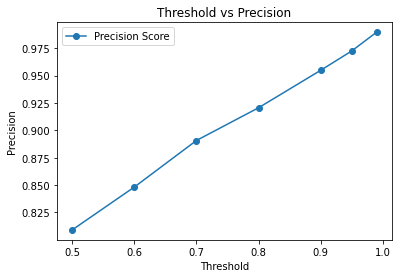

In [69]:
# use this function for deliverable 3.5
# this function gives an array of 0 or 1. it is 1 if it is greater than tau and 0 if not.
def threshold(probs, tau):
    return np.where(probs[:,1] > tau, 1, 0)

# your logistic regression code here

classifier = SGDClassifier(loss = 'log', max_iter = 1000, tol = 1.0e-12, random_state = 123, average = False)
classifier.fit(X_train, Y_train)

plt.title('Threshold vs Precision')
plt.plot(tau, precision, label = 'Precision Score', marker = 'o')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

#### Deliverable 3.6

Describing the observations and what happens to the precision of the threshold as it increases.

    As the precision score increases, the values increase for threshold, closer to 1. I believe this happens because accuracy_scores tells us if it was a natural disaster   or not, and the precision score tells us whether or not the score actually represented a natural disaster or not. In essence, Precision increased because the threshold was high, any tweets classified closer to 1 were in a higher threshold, and showed actual disasters.